# Mus

In [17]:
import pickle
import pandas as pd
import numpy as np
import glob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load hlrc
with open('derived_data/hlrc.pkl', 'rb') as f:
    hlrc = pickle.load(f)
    
# load hfrc
with open('derived_data/hfrc.pkl', 'rb') as f:
    hfrc = pickle.load(f)

# load horc
file_path = "../../results/horc/"
filename = "mus.mean.orc.json"

idx = []
documents = []
with open(os.path.join(file_path, filename), "r") as f:
    data = json.load(f)
    for key, value in enumerate(data):
        idx.append(int(key))
        documents.append(data[key])
sorted_idx = sorted(range(len(idx)), key=lambda i: idx[i])
idx_sorted = [idx[i] for i in sorted_idx]
documents = [documents[i] for i in sorted_idx]
horc = [np.array(document['edge_curvature']) for document in documents]

In [4]:
# graph labels
graph_dir = "../../data/raw/mus/mus"

file_paths = glob.glob(os.path.join(graph_dir, "*.csv"))
hg_labels = pd.Series([os.path.basename(f).split("_")[0] for f in file_paths])
hg_labels.value_counts()

palestrina    1318
bach           410
trecento       102
monteverdi      49
beethoven       22
mozart          16
schumann        12
haydn            9
chopin           1
handel           1
joplin           1
schubert         1
verdi            1
weber            1
Name: count, dtype: int64

In [5]:
hg_labels.unique()

array(['bach', 'beethoven', 'chopin', 'handel', 'haydn', 'joplin',
       'monteverdi', 'mozart', 'palestrina', 'schubert', 'schumann',
       'trecento', 'verdi', 'weber'], dtype=object)

In [6]:
Renaissance = ['monteverdi', 'trecento']
Baroque = ['bach','handel']
Later = ['haydn', 'mozart', 'beethoven', 'schumann','schubert','chopin','verdi','weber','joplin']

groups = {
    'Renaissance': Renaissance,
    'Baroque': Baroque,
    'Later': Later
}

color_map = {
    "Renaissance": '#c1272d',
    "Baroque":'#114684',
    "Later": '#d4872f',
}

mask = np.isin(hg_labels, Renaissance + Baroque + Later)

## KPCA

In [11]:
import glob
import re

import numpy as np
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import scale
import pymp

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

def pmap(f, x, num_threads):
    y = pymp.shared.list([None] * len(x))
    with pymp.Parallel(num_threads) as p:
        for i in p.range(len(x)):
            y[i] = f(x[i])
    return list(y)

def _binning(C, bins):
    def H(c):
        h = np.histogram(c, bins)[0]
        return h / sum(h)

    return list(pmap(H, C, 64))


def horc_histogram(C):
    return _binning(C, [x / 100 for x in range(-200, 104, 5)])

def hlrc_histogram(C):
    return _binning(C, [x / 100 for x in range(-100, 104, 5)])


def kpca(histogram, k):
    pca = KernelPCA(n_components=k, kernel="precomputed", tol=1e-5, max_iter=2000)
    D = rbf_kernel(histogram)
    embedding = pca.fit_transform(D)
    
    return embedding

In [35]:
def plot_embed(X, labels, groups,fig_out=None):
    plt.figure(figsize=(6, 4))
    for group_name, members in groups.items():
        grp_idx = np.isin(labels, members)
        plt.scatter(
            X[grp_idx, 0],
            X[grp_idx, 1],
            label=group_name,
            color=color_map[group_name],
            alpha=0.7
        )

    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if fig_out:
        plt.savefig(fig_out)
    plt.show()

    kmeans = KMeans(n_clusters=3, random_state=42)
    predicted_labels = kmeans.fit_predict(X)

    # Compute the Adjusted Rand Index (ARI)
    ari_score = adjusted_rand_score(labels, predicted_labels)
    print("HORC Adjusted Rand Index (ARI):", ari_score)
    ami_score = adjusted_mutual_info_score(labels, predicted_labels)
    print("HORC Adjusted Mutual Info Score (AMI):", ami_score)

### HLRC

In [36]:
hlrc_embed = kpca(hlrc_histogram(hlrc), 2)

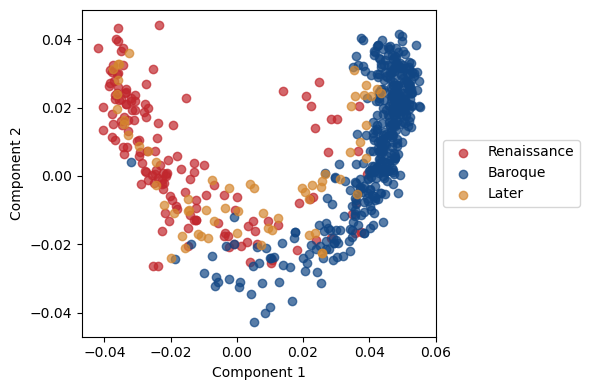

HORC Adjusted Rand Index (ARI): 0.3979051347208215
HORC Adjusted Mutual Info Score (AMI): 0.3205604749977656


In [37]:
plot_embed(hlrc_embed[mask], hg_labels[mask], groups,fig_out="figures/Mus_HLRC_kpca.pdf")

### HORC

In [38]:
import json
file_path = "../../results/horc/"
filename = "mus.mean.orc.json"

idx = []
documents = []
with open(os.path.join(file_path, filename), "r") as f:
    data = json.load(f)
    for key, value in enumerate(data):
        idx.append(int(key))
        documents.append(data[key])
sorted_idx = sorted(range(len(idx)), key=lambda i: idx[i])
idx_sorted = [idx[i] for i in sorted_idx]
documents = [documents[i] for i in sorted_idx]
hg_horc = [np.array(document['edge_curvature']) for document in documents]

In [39]:
horc_embed = kpca(horc_histogram(hg_horc), 2)

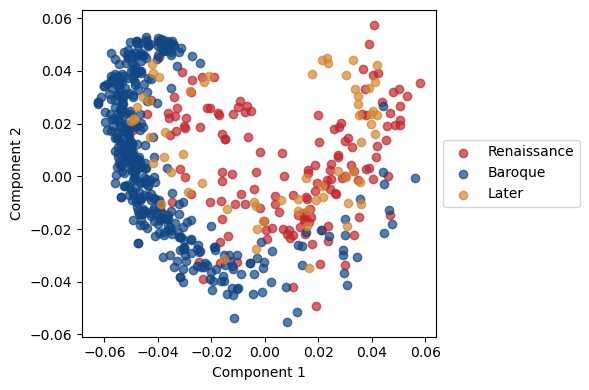

HORC Adjusted Rand Index (ARI): 0.20529430001340496
HORC Adjusted Mutual Info Score (AMI): 0.18216112523780342


In [40]:
plot_embed(horc_embed[mask], hg_labels[mask], groups,fig_out="figures/Mus_HORC_kpca.pdf")

## Histogram per sematic group

In [8]:
# Renaissance = ['monteverdi', 'trecento']
# Baroque = ['bach','handel']
# Later = ['haydn', 'mozart', 'beethoven', 'schumann','schubert','chopin','verdi','weber','joplin']

# build a mapping dict
era_map = {name: 'Renaissance' for name in Renaissance}
era_map.update({name: 'Baroque'      for name in Baroque})
era_map.update({name: 'Later'    for name in Later})

# apply mapping
era_labels = [era_map.get(lbl, 'Other') for lbl in hg_labels]

In [9]:
expanded_labels = [label for label, curvs in zip(era_labels, hlrc) for _ in curvs]

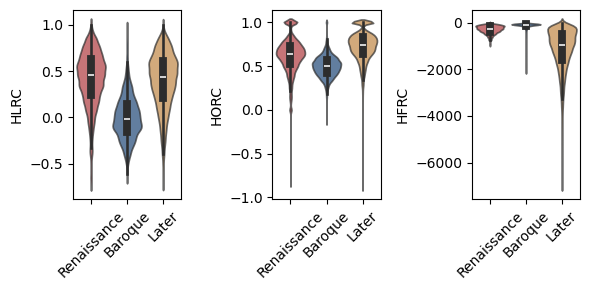

In [42]:
flat_hlrc = [c for sublist in hlrc for c in sublist]
flat_horc = [c for sublist in horc for c in sublist]
flat_hfrc = [c for sublist in hfrc for c in sublist]


# Create DataFrame
mus_df = pd.DataFrame({
    "hlrc": flat_hlrc,
    "horc": flat_horc,
    "hfrc": flat_hfrc,
    "label": expanded_labels
})

fig, axes = plt.subplots(1, 3, figsize=(6, 3))
order = ['Renaissance','Baroque','Later']
# --- Plot 1: HLRC ---
sns.violinplot(data=mus_df[mus_df.label != "Other"], x="label", y="hlrc",hue="label",
               ax=axes[0], order=order,palette=color_map,legend=False, alpha=0.7)
axes[0].set_title("")
axes[0].set_xlabel("")
axes[0].set_ylabel("HLRC")
axes[0].tick_params(axis='x', rotation=45)

# --- Plot 2: HORC ---
sns.violinplot(data=mus_df[mus_df.label != "Other"], x="label", y="horc",hue="label",
               ax=axes[1], order=order,palette=color_map,legend=False, alpha=0.7)
axes[1].set_title("")
axes[1].set_xlabel("")
axes[1].set_ylabel("HORC")
axes[1].tick_params(axis='x', rotation=45)

# --- Plot 3: HFRC ---
sns.violinplot(data=mus_df[mus_df.label != "Other"], x="label", y="hfrc",hue="label",
               ax=axes[2], order=order, palette=color_map,legend=False, alpha=0.7)
axes[2].set_title("")
axes[2].set_xlabel("")
axes[2].set_ylabel("HFRC")
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.savefig("figures/Violinplot_per_era.pdf")
plt.show()